In [1]:
import sys
sys.path.append('../Main-Version/')

from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl
import Integ_analysis as int_analysis
import Transmission_calculation as trans_calc
import pandas as pd

In [2]:
#Following function plots integration transmission average for parallel observations
def plot_parallel_integ(analysis,guide,aperture_VIS,aperture_NIR,VIS_band,normalise="no AD",method="numerical moffat",
                        aperture="hexagons",sample_val=[1*u.nm,1*u.nm],scale_val=0.01):  
    if VIS_band=="G":
        VIS_band="V"
    weights_VIS = np.arange(0, len(aperture_VIS)+2)
    norm_VIS = mpl.colors.Normalize(vmin=min(weights_VIS), vmax=max(weights_VIS))
    cmap_VIS = mpl.cm.ScalarMappable(norm=norm_VIS, cmap=mpl.cm.Blues)

    weights_NIR = np.arange(0, len(aperture_NIR)+2)
    norm_NIR = mpl.colors.Normalize(vmin=min(weights_NIR), vmax=max(weights_NIR))
    cmap_NIR= mpl.cm.ScalarMappable(norm=norm_NIR, cmap=mpl.cm.Reds)
       
    analysis.load_band("LR","VIS",VIS_band,VIS_band,sampling=sample_val[0])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_VIS,guide)
    print(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_VIS[count]),color=cmap_VIS.to_rgba(len(aperture_VIS)-count))
        plt.plot(analysis.output['wavelengths'],opt_transmission,color='black',linestyle='--')
        
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_VIS[count]),color=cmap_VIS.to_rgba(len(aperture_VIS)-count))

    analysis.load_band("LR","NIR","IY","H",sampling=sample_val[1])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_NIR,guide)
    print(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_NIR.to_rgba(len(aperture_NIR)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output['wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_NIR.to_rgba(len(aperture_NIR)-count))
        plt.axhline(y=1,label='No AD Transmission, {}'.format(analysis.input['method']),color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guide Wavelength = {}'.format(guide))
    #if analysis.input['HA_range'] != []:
        #plt.title("Guide = {}, HA {}-{}, Dec = {}, Centre at = {}h".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec'],analysis.input['HA_range'][analysis.input['centred_on']]))
    plt.legend()

In [3]:
def optimise_parallel(analysis,guide_options,VIS_aperture_centre_options,NIR_aperture_centre_options,VIS_band,scale_val=0.01):
    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    VIS_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,VIS_aperture_centre_options,guide)
        VIS_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    
    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    NIR_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,NIR_aperture_centre_options,guide)
        NIR_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    
    #Need to go through each guide and each permutation of VIS and NIR
    performance_metrics_v1=[]
    performance_metrics_v2=[]
    performance_metrics_v3=[]
    performance_metrics_v4=[]
    for i in range(0,len(guide_options)):
        metric_outer_v1=[]
        metric_outer_v2=[]
        metric_outer_v3=[]
        metric_outer_v4=[]
        for o in range(0,len(VIS_aperture_centre_options)):
            metric_inner_v1=[]
            metric_inner_v2=[]
            metric_inner_v3=[]
            metric_inner_v4=[]
            for p in range(0,len(NIR_aperture_centre_options)):
                VIS_min=VIS_metrics[i][o][0]
                VIS_max=VIS_metrics[i][o][1]
                VIS_throughput=VIS_metrics[i][o][2]
                
                NIR_min=NIR_metrics[i][p][0]
                NIR_max=NIR_metrics[i][p][1]
                NIR_throughput=NIR_metrics[i][p][2]

                metric_v1=(VIS_min/VIS_max)*VIS_throughput*(NIR_min/NIR_max)*NIR_throughput
                metric_v2=(VIS_min/VIS_max)*VIS_throughput**2*(NIR_min/NIR_max)*NIR_throughput**2
                
                metric_v3=(VIS_min)*VIS_throughput*(NIR_min)*NIR_throughput
                metric_v4=(VIS_min)*VIS_throughput**2*(NIR_min)*NIR_throughput**2 
                             
                metric_inner_v1.append(metric_v1)
                metric_inner_v2.append(metric_v2)
                metric_inner_v3.append(metric_v3)
                metric_inner_v4.append(metric_v4)
                
            metric_outer_v1.append(metric_inner_v1)
            metric_outer_v2.append(metric_inner_v2)
            metric_outer_v3.append(metric_inner_v3)
            metric_outer_v4.append(metric_inner_v4)
                       
        performance_metrics_v1.append(metric_outer_v1)
        performance_metrics_v2.append(metric_outer_v2)
        performance_metrics_v3.append(metric_outer_v3)
        performance_metrics_v4.append(metric_outer_v4)
           
    best_metric_v1=0
    best_metric_v2=0
    best_metric_v3=0
    best_metric_v4=0
    for i in range(0,len(guide_options)):
        for o in range(0,len(VIS_aperture_centre_options)):
            for p in range(0,len(NIR_aperture_centre_options)):
                if performance_metrics_v1[i][o][p]>best_metric_v1:
                    best_metric_v1=performance_metrics_v1[i][o][p]
                    best_guide_v1=guide_options[i]
                    best_VIS_aperture_v1=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v1=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v1=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v1=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                    
                if performance_metrics_v2[i][o][p]>best_metric_v2:
                    best_metric_v2=performance_metrics_v2[i][o][p]
                    best_guide_v2=guide_options[i]
                    best_VIS_aperture_v2=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v2=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v2=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v2=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
 
                if performance_metrics_v3[i][o][p]>best_metric_v3:
                    best_metric_v3=performance_metrics_v3[i][o][p]
                    best_guide_v3=guide_options[i]
                    best_VIS_aperture_v3=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v3=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v3=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v3=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                    
                if performance_metrics_v4[i][o][p]>best_metric_v4:
                    best_metric_v4=performance_metrics_v4[i][o][p]
                    best_guide_v4=guide_options[i]
                    best_VIS_aperture_v4=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v4=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v4=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v4=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                          
    best_metric_combo_v1=[best_metric_v1,best_VIS_metrics_v1,best_NIR_metrics_v1]
    best_metric_combo_v2=[best_metric_v2,best_VIS_metrics_v2,best_NIR_metrics_v2]
    best_metric_combo_v3=[best_metric_v3,best_VIS_metrics_v3,best_NIR_metrics_v3]
    best_metric_combo_v4=[best_metric_v4,best_VIS_metrics_v4,best_NIR_metrics_v4]
    
    return [best_guide_v1,best_VIS_aperture_v1,best_NIR_aperture_v1,best_metric_combo_v1],[best_guide_v2,best_VIS_aperture_v2,best_NIR_aperture_v2,best_metric_combo_v2],[best_guide_v3,best_VIS_aperture_v3,best_NIR_aperture_v3,best_metric_combo_v3],[best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4]

Target goes below Horizon above/below HA of +/- 6.2h
[[0.779044316609507, 0.9558234189816285, 0.9058707061346002]]
[[0.8091645392933148, 0.9750120796992958, 0.9146170121201536]]
Target goes below Horizon above/below HA of +/- 6.2h
[[0.7884404211078097, 0.9770224227015989, 0.9232956311644496]]
[[0.7985333706782943, 0.9462284525897471, 0.8892914984206806]]


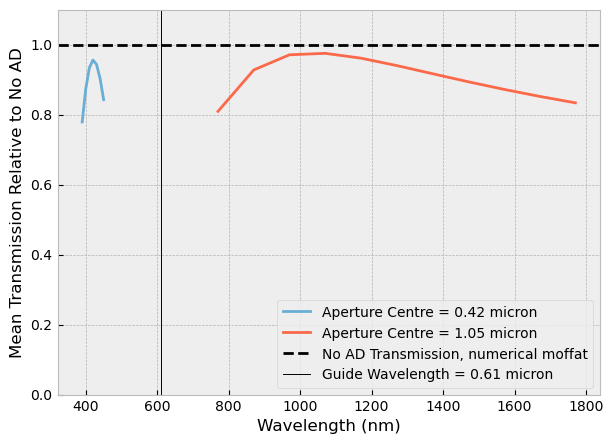

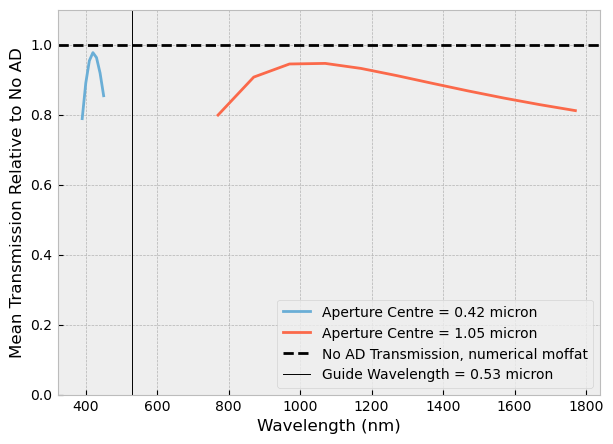

In [ ]:
analysis=AD_analysis()
HA_range=np.linspace(2.5,3.5,21)
targ_dec=-5*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.61*u.micron,[.42]*u.micron,[1.05]*u.micron,"B",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm])

analysis=AD_analysis()
HA_range=np.linspace(2.5,3.5,21)
targ_dec=-5*u.deg
analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_parallel_integ(analysis,0.53*u.micron,[.42]*u.micron,[1.05]*u.micron,"B",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm])


In [4]:
def optimise_parallel(analysis,guide_options,VIS_aperture_centre_options,NIR_aperture_centre_options,VIS_band,scale_val=0.01):
    analysis.load_band('LR','VIS',VIS_band,VIS_band,sampling=1*u.nm)
    analysis.load_wave(.702*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    VIS_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,VIS_aperture_centre_options,guide)
        VIS_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    
    analysis.load_band('LR','NIR','IY','H',sampling=1*u.nm) 
    analysis.load_wave(.570*u.arcsec,min(analysis.output['wavelengths']).value,max(analysis.output['wavelengths']).value,segments=10)
    analysis.make_aperture("hexagons",method="numerical moffat",scale=scale_val)
    NIR_metrics=[] #will be of the form [[[G1 A1 min, max, mean],[G1 A2 min, max, mean]...][[G2 A1 min, max, mean...]...]...]
    #first index is guide, second index is aperture centre, third index in min, max, or mean
    for guide in guide_options:
        integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,NIR_aperture_centre_options,guide)
        NIR_metrics.append(int_analysis.integ_metric(np.array(integ_transmissions)/np.array(opt_transmission)))
    
    #Need to go through each guide and each permutation of VIS and NIR

    performance_metrics_v4=[]
    for i in range(0,len(guide_options)):

        metric_outer_v4=[]
        for o in range(0,len(VIS_aperture_centre_options)):

            metric_inner_v4=[]
            for p in range(0,len(NIR_aperture_centre_options)):
                VIS_min=VIS_metrics[i][o][0]
                VIS_max=VIS_metrics[i][o][1]
                VIS_throughput=VIS_metrics[i][o][2]
                
                NIR_min=NIR_metrics[i][p][0]
                NIR_max=NIR_metrics[i][p][1]
                NIR_throughput=NIR_metrics[i][p][2]
                
                metric_v4=(VIS_min)*VIS_throughput**2*(NIR_min)*NIR_throughput**2 
                            
                metric_inner_v4.append(metric_v4)
                
            metric_outer_v4.append(metric_inner_v4)
                       
        performance_metrics_v4.append(metric_outer_v4)
           
    best_metric_v4=0
    for i in range(0,len(guide_options)):
        for o in range(0,len(VIS_aperture_centre_options)):
            for p in range(0,len(NIR_aperture_centre_options)):
                    
                if performance_metrics_v4[i][o][p]>best_metric_v4:
                    best_metric_v4=performance_metrics_v4[i][o][p]
                    best_guide_v4=guide_options[i]
                    best_VIS_aperture_v4=VIS_aperture_centre_options[o]
                    best_NIR_aperture_v4=NIR_aperture_centre_options[p]
                    
                    best_VIS_metrics_v4=[VIS_metrics[i][o][0],VIS_metrics[i][o][1],VIS_metrics[i][o][2]]
                    best_NIR_metrics_v4=[NIR_metrics[i][p][0],NIR_metrics[i][p][1],NIR_metrics[i][p][2]]
                          

    best_metric_combo_v4=[best_metric_v4,best_VIS_metrics_v4,best_NIR_metrics_v4]
    
    return [best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4]

VIS_B=[.390,.458]
VIS_V=[.450,.591] 
VIS_R=[.586,.770]
NIR_All=[.770,1.857]
fields=[2.2,-5.2,-27.8,-60.5,-69.8,-72.8]
HA_mids=0,1,2,3,4
bands=["B","G","R"]

Target goes below Horizon above/below HA of +/- 5.9h
0.79 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.970665973227277, 0.9990937117973051, 0.9903799013320937]]
[[0.9493075747435454, 0.9987758367849278, 0.9791692413999226]]
Target goes below Horizon above/below HA of +/- 5.9h
0.79 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.9618688560891565, 0.9989553795951723, 0.9873692051156131]]
[[0.9332767870351025, 0.9985654011562431, 0.9728994243273561]]
Target goes below Horizon above/below HA of +/- 5.9h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.9325966257320901, 0.9981997059798606, 0.9770226197969313]]
[[0.8822621806963701, 0.9979669912492213, 0.9524233298671516]]
Target goes below Horizon above/below HA of +/- 5.9h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 5.9h
[[0.8751942885457736, 0.9961623654658522,

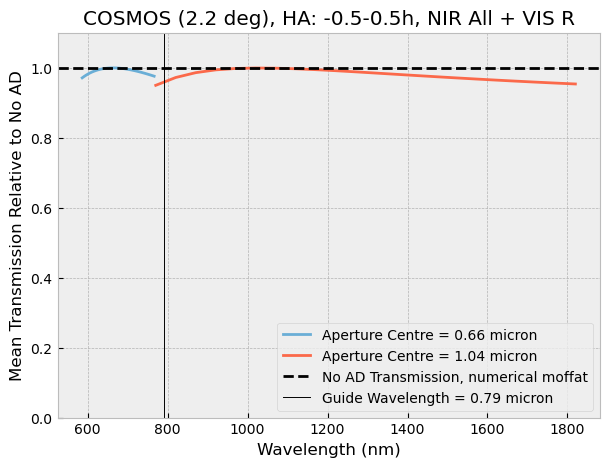

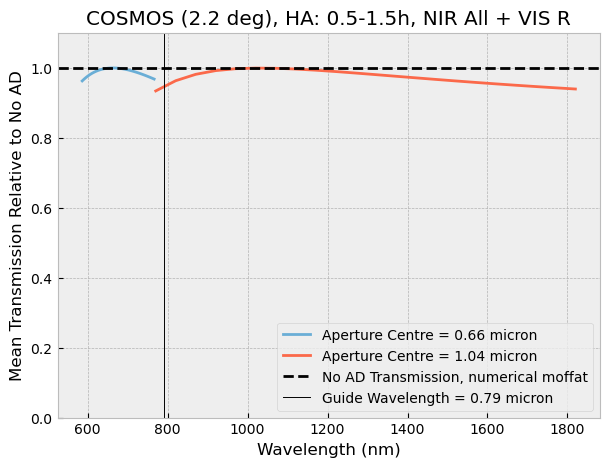

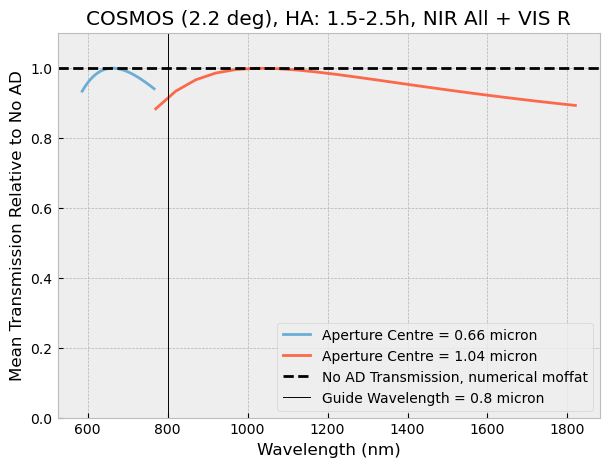

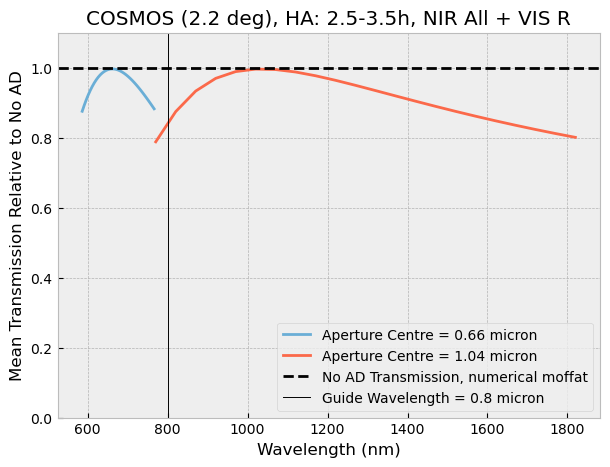

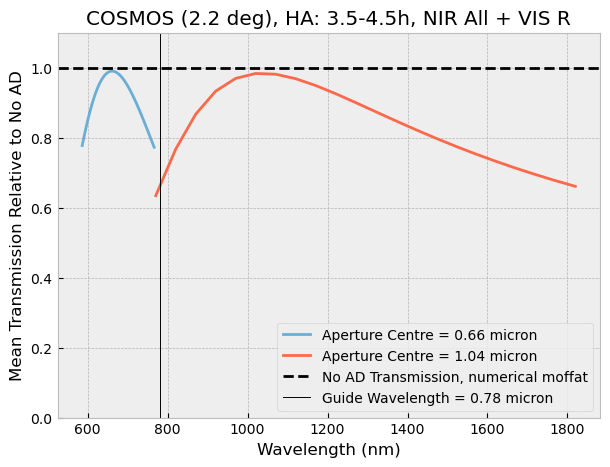

In [9]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[0]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]


    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("COSMOS ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))

    

Target goes below Horizon above/below HA of +/- 6.2h
0.81 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.2h
[[0.9835013592534012, 0.9990116238401482, 0.994607036249254]]
[[0.9740785092007247, 0.9991556734634196, 0.9887905112244746]]
Target goes below Horizon above/below HA of +/- 6.2h
0.79 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.2h
[[0.9759428219354098, 0.9990589791093586, 0.9921091610905894]]
[[0.9592543399170111, 0.9987423618265586, 0.9828122707797736]]
Target goes below Horizon above/below HA of +/- 6.2h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.2h
[[0.9495203710074387, 0.9984246293334788, 0.9829297122181772]]
[[0.9117490724875997, 0.9982558792229951, 0.9644101584528105]]
Target goes below Horizon above/below HA of +/- 6.2h
0.81 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.2h
[[0.8972000455094457, 0.9965061524562904

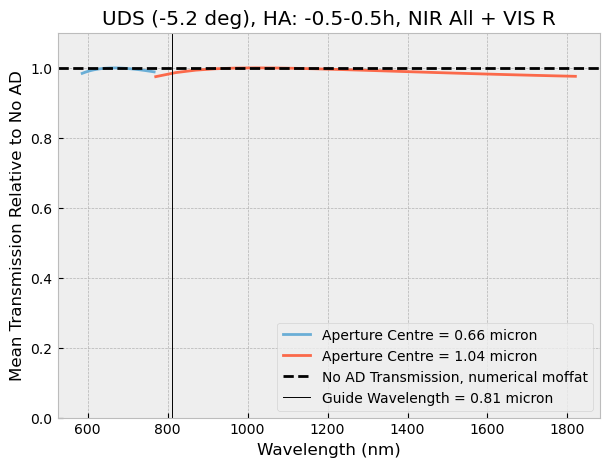

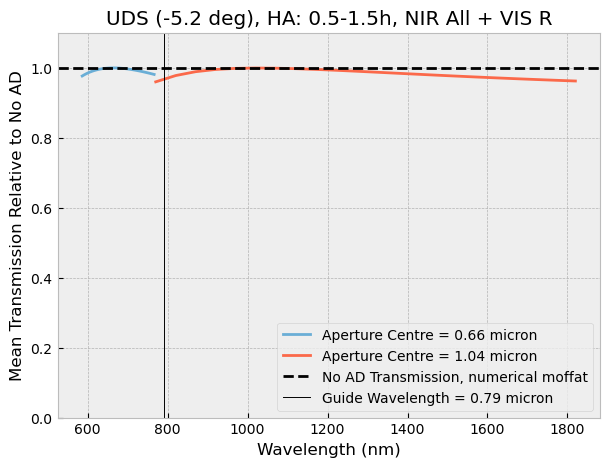

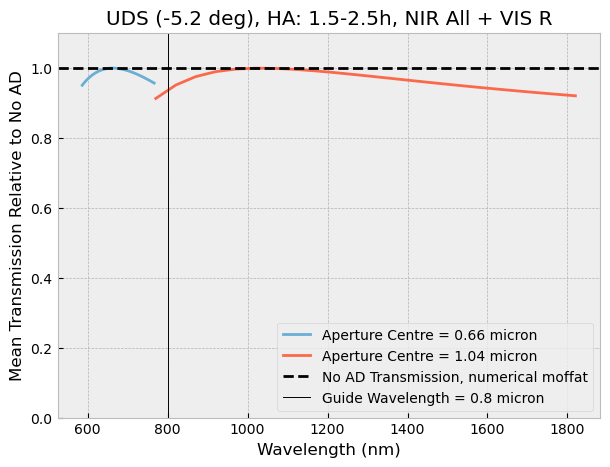

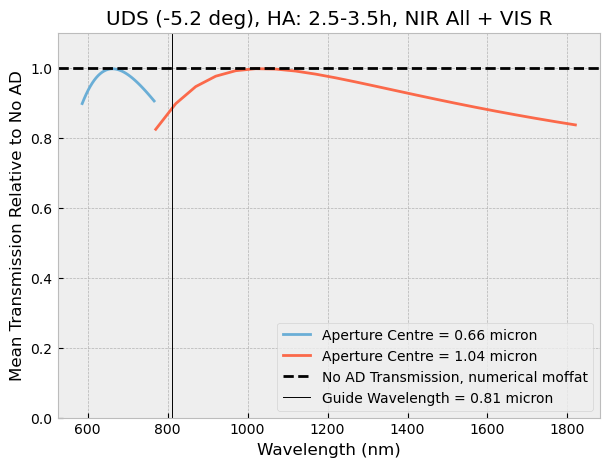

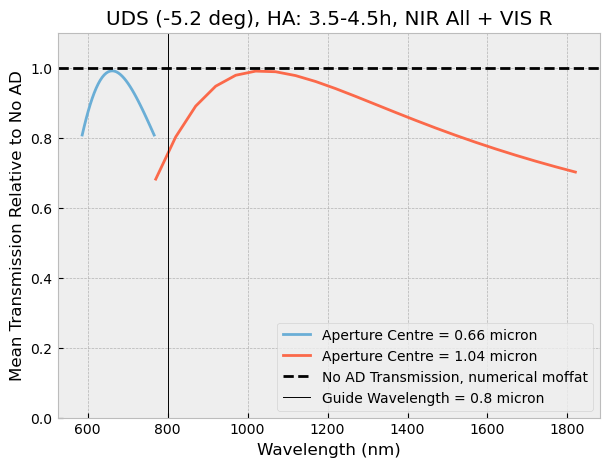

In [33]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[1]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("UDS ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))


Target goes below Horizon above/below HA of +/- 6.9h
0.88 micron [0.64] micron [1.19] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9956996961344005, 0.9992299287825033, 0.9982684380523723]]
[[0.9973718764666031, 0.9997254770678934, 0.9987137014822197]]
Target goes below Horizon above/below HA of +/- 6.9h
0.83 micron [0.65] micron [1.05] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9913863033538126, 0.9986531396259913, 0.9963601795512633]]
[[0.986464861728334, 0.9993234071498464, 0.993992309044438]]
Target goes below Horizon above/below HA of +/- 6.9h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9700806076015566, 0.9987314468724701, 0.989957764529657]]
[[0.948524206652591, 0.9986354808747948, 0.9789282399374154]]
Target goes below Horizon above/below HA of +/- 6.9h
0.81 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 6.9h
[[0.9299883160500512, 0.9976204551758799, 0

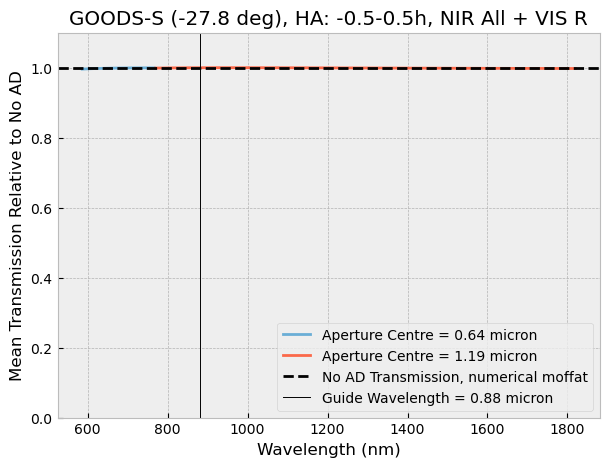

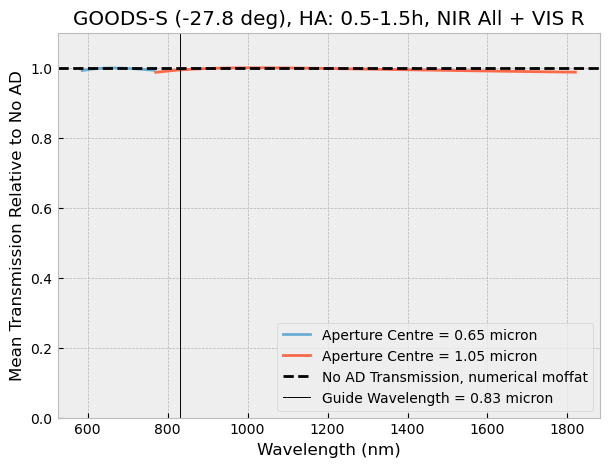

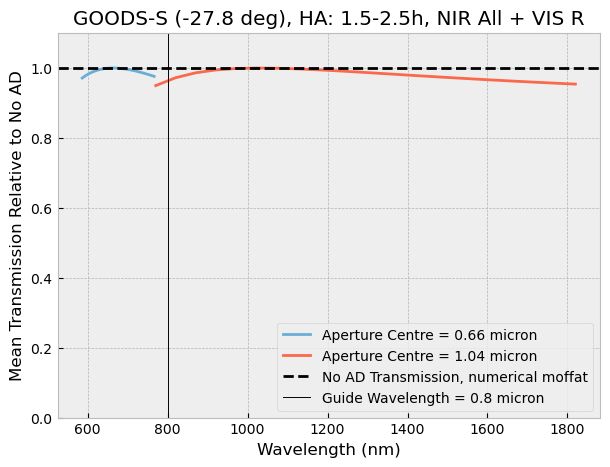

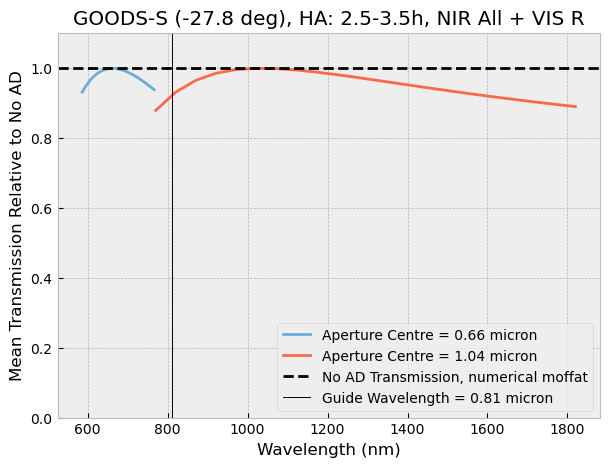

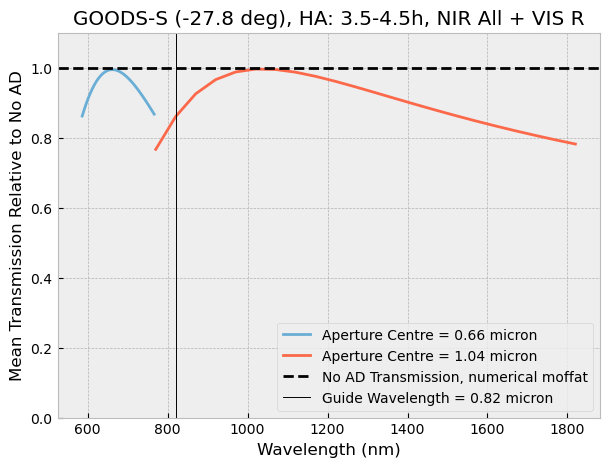

In [34]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[2]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("GOODS-S ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))


Target goes below Horizon above/below HA of +/- 9.6h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.9471449902347732, 0.9988217746184056, 0.9820902555888392]]
[[0.9052837836636186, 0.998614015738413, 0.9628410693115235]]
Target goes below Horizon above/below HA of +/- 9.6h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.9421899330733431, 0.9987567262146521, 0.980355348662252]]
[[0.896557792037285, 0.9985272125892293, 0.9593223930576477]]
Target goes below Horizon above/below HA of +/- 9.6h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.9267982554802736, 0.9985386760369762, 0.9749038254717102]]
[[0.8699648915165576, 0.9982411005855387, 0.9483762086099911]]
Target goes below Horizon above/below HA of +/- 9.6h
0.8 micron [0.66] micron [1.04] micron
Target goes below Horizon above/below HA of +/- 9.6h
[[0.8994404761609306, 0.9980835964217867, 0.9

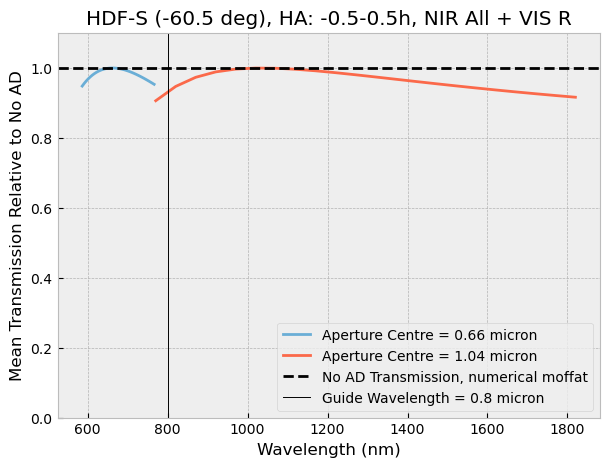

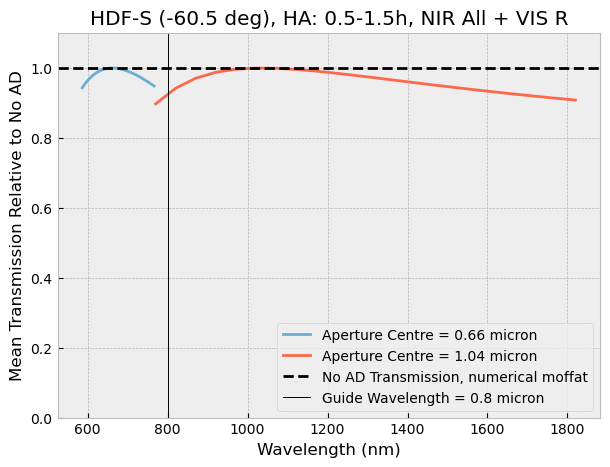

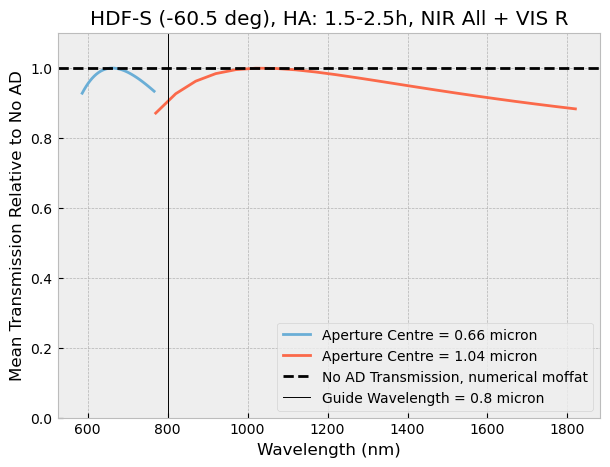

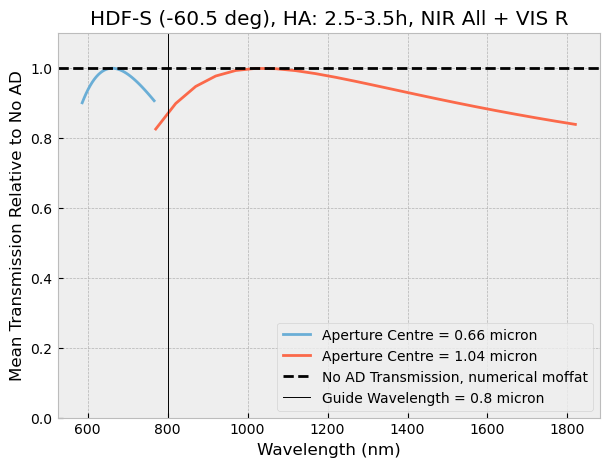

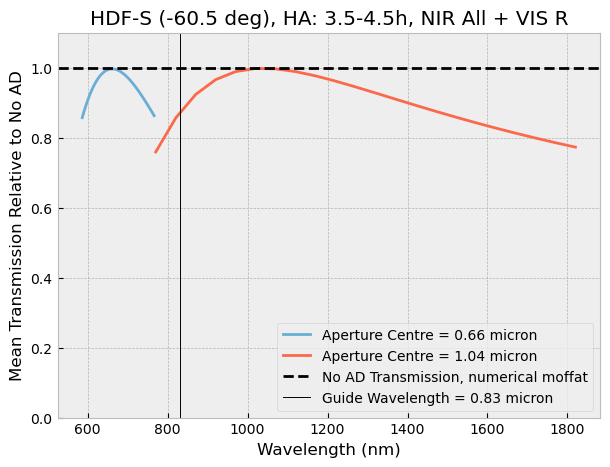

In [35]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[3]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("HDF-S ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))


/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/MOSAIC/AD/AD-Code/Main-Version/AD_analysis.py:150: RuntimeWarning: invalid value encountered in arccos
  LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15


0.8 micron [0.66] micron [1.04] micron
[[0.9099823128630777, 0.9985565185837596, 0.9689843265401916]]
[[0.8413991739200603, 0.9981818749759955, 0.9365188433049412]]
0.8 micron [0.66] micron [1.04] micron
[[0.9057431868759018, 0.9985009773917854, 0.9674498457487266]]
[[0.8344316698831747, 0.9981071809140125, 0.9335058753837983]]
0.81 micron [0.66] micron [1.04] micron
[[0.8925600224327528, 0.9981439278660469, 0.9625607149208572]]
[[0.8134870321161203, 0.9980648603414646, 0.9245614375988713]]
0.83 micron [0.66] micron [1.04] micron
[[0.8697567239373941, 0.9973299557970361, 0.9538485909812123]]
[[0.7785021650723922, 0.9980592028372276, 0.9092773021271444]]
0.83 micron [0.66] micron [1.04] micron
[[0.8372176173778404, 0.9965509598904625, 0.9412278271173212]]
[[0.7295937219659671, 0.9974943377134132, 0.8864114235091258]]


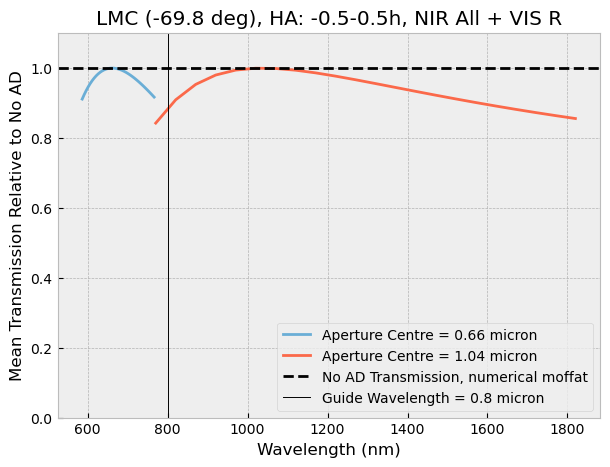

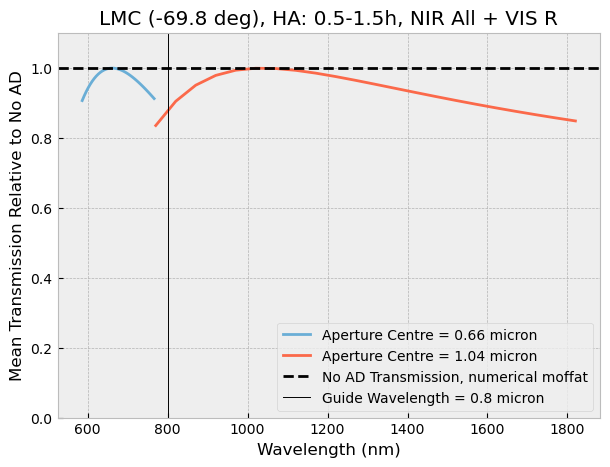

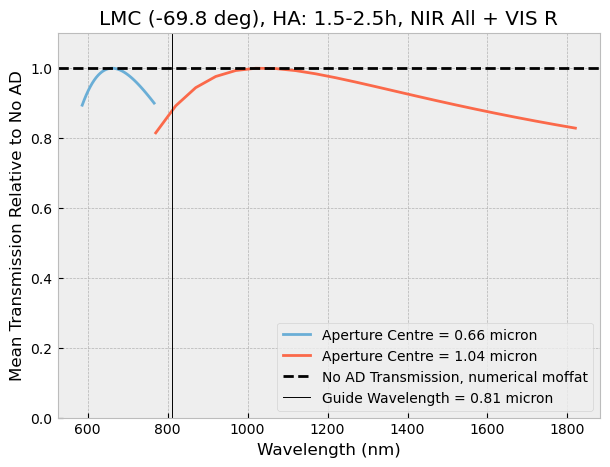

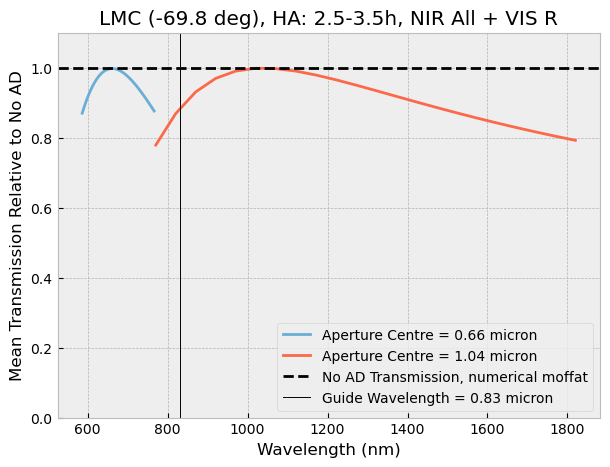

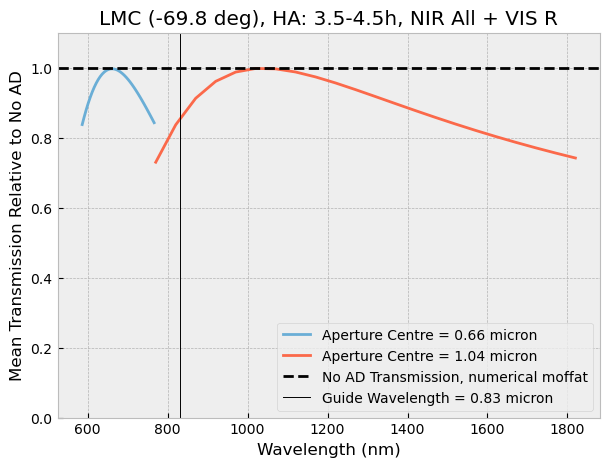

In [36]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[4]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("LMC ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))

    int_analysis.track_plot(analysis,"mid HA")

0.81 micron [0.66] micron [1.04] micron
[[0.8942922529193909, 0.9982749565987337, 0.9632595553771937]]
[[0.8161820770316908, 0.9981768496649123, 0.9258136911485515]]
0.82 micron [0.66] micron [1.04] micron
[[0.8901510132008223, 0.9980455968790991, 0.9616660070296427]]
[[0.8099449899898012, 0.998282471414144, 0.9232736181240495]]
0.83 micron [0.66] micron [1.04] micron
[[0.8780353336054896, 0.9976575516945668, 0.9570796323792502]]
[[0.7912501798744975, 0.9982673183986985, 0.915113277394749]]
0.83 micron [0.66] micron [1.04] micron
[[0.8578055626464987, 0.9972596302714, 0.9494066678845966]]
[[0.7602349573350844, 0.9979630820874409, 0.9008885278014618]]
0.83 micron [0.66] micron [1.04] micron
[[0.8287573260317311, 0.9966065653310106, 0.9380785964164937]]
[[0.7173174353110675, 0.9974784789798306, 0.8805205068756686]]


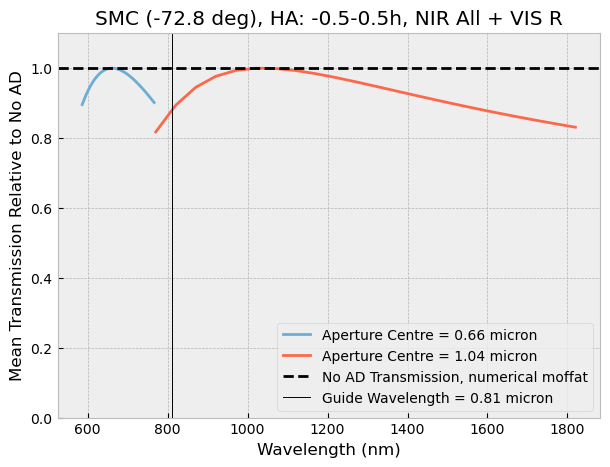

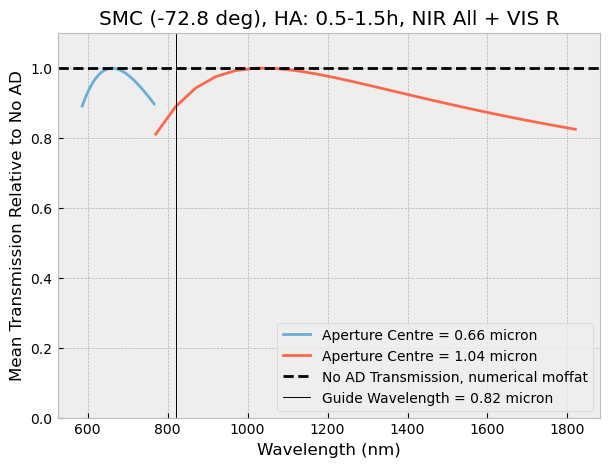

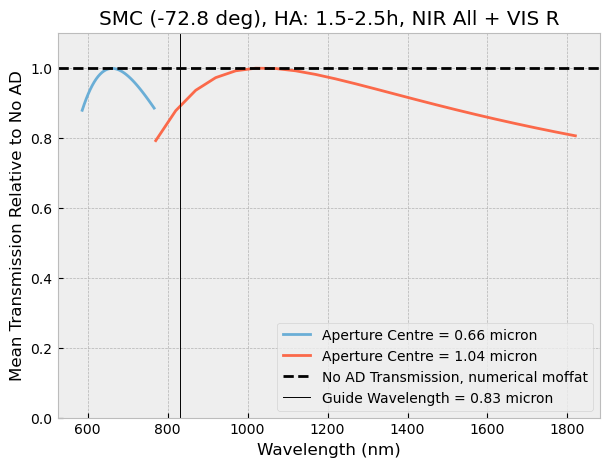

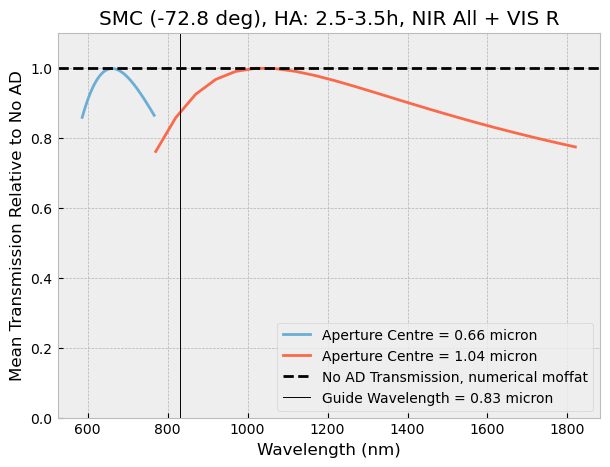

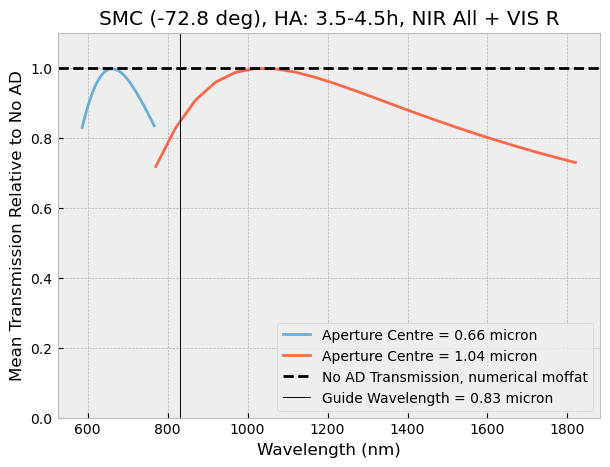

In [38]:
for i in range(0,len(HA_mids)):
    HA_range=np.linspace(HA_mids[i]-0.5,HA_mids[i]+0.5,11)
    targ_dec=fields[5]*u.deg
    centring="mid HA"

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)

    v4=optimise_parallel(analysis,np.arange(.75,.95,.01)*u.micron,np.arange(.64,.69,.01)*u.micron,np.arange(1,1.2,.01)*u.micron,'R',scale_val=0.01)
    best_guide_v4,best_VIS_aperture_v4,best_NIR_aperture_v4,best_metric_combo_v4=v4[0],v4[1],v4[2],v4[3]

    aperture_VIS_v4=[round(best_VIS_aperture_v4.value,2)]*u.micron
    aperture_NIR_v4=[round(best_NIR_aperture_v4.value,2)]*u.micron
    guide_v4=round(best_guide_v4.value,2)*u.micron   
    
    print(guide_v4,aperture_VIS_v4,aperture_NIR_v4)

    analysis=AD_analysis()
    analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
    plot_parallel_integ(analysis,guide_v4,aperture_VIS_v4,aperture_NIR_v4,"R",method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,50*u.nm])
    plt.title("SMC ({}), HA: {}-{}h, NIR All + VIS R".format(targ_dec,HA_range[0],HA_range[-1]))

    int_analysis.track_plot(analysis,"mid HA")